In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
import os

In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [4]:
cuda=True

In [10]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

trainL = ImageDataset(dataset=datasets.TRAINING_LABELED,network_input_size=256, cuda=cuda)
trainU = ImageDataset(dataset=datasets.TRAINING_UNLABELED,network_input_size=256, cuda=cuda)
trainC = ConcatDataset([trainL,trainU])
train_size = int(0.8*len(trainC))
val_size = len(trainC)-train_size
train,val = random_split(trainC,[train_size,val_size])
test = ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda)
valL = ImageDataset(datasets.VALIDATION_20,network_input_size=256,cuda=cuda)


trainL = DataLoader(trainL,128,True)
train = DataLoader(train,128,True)
val = DataLoader(val,128,True)
test = DataLoader(test,128,True)
valL = DataLoader(valL,128,True)

In [6]:
from utils.v2 import Autoencoder

In [ ]:
autoencoder = Autoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

train_loss = []
val_loss = []

num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    autoencoder.train()
    running_loss = 0.0
    print('Training:')
    i = 0
    for inputs,_ in train:
        i = i+1
        if i%20 == 0:
            print(f'Batch {i} di {len(train)}')
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Train_Loss: {running_loss/len(train)}')
    train_loss.append(running_loss/len(train))
    autoencoder.eval()
    running_loss = 0.0
    print('Validation:')
    i = 0
    for inputs,_ in val:
        i = i+1
        if i%20 == 0:
            print(f'Batch {i} di {len(val)}')
        inputs = inputs.to(device)
        outputs = autoencoder(inputs)
        loss = criterion(outputs,inputs)
        running_loss += loss.item()
    print(f'Validation_Loss: {running_loss/len(val)}')
    val_loss.append(running_loss/len(val))

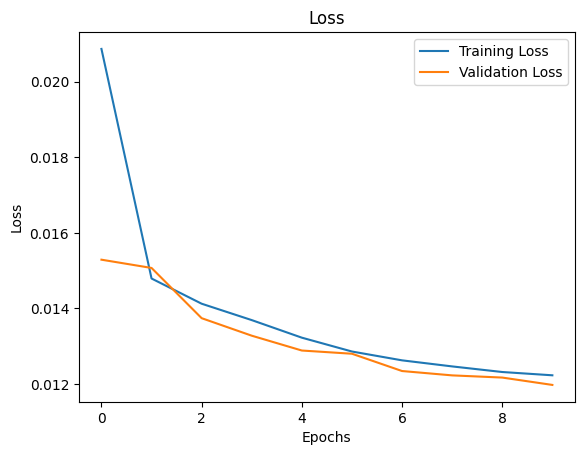

In [8]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
    
plot_loss(train_loss,val_loss)

In [9]:
encoder = autoencoder.encoder

In [10]:
torch.save(encoder, "SSEncoderV2.pth")

In [7]:
from utils.v2 import ExtendedEncoder

In [8]:
from utils.v2 import Encoder
encoder = torch.load("self-supervised/models/SSEncoderV2.pth")

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exEncoder = ExtendedEncoder(encoder)
exEncoder.to(device)
train_loss = []
val_loss = []
train_acc = []
val_acc = []
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(exEncoder.parameters(), lr = 5e-6)
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exEncoder.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainL:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainL)}')
        labels = [int(label) for label in labels]
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exEncoder(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exEncoder.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,lables in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            lables=[int(lable) for lable in lables]
            inputs,lables = inputs.to(device), torch.tensor(lables,dtype=torch.long).to(device)
            outputs = exEncoder(inputs)
            _,predicted = torch.max(outputs,1)
            total += lables.size(0)
            correct += (predicted == lables).sum().item()
            loss = criterion(outputs,lables)
            running_loss += loss.item()
    print(f'Validation Loss: {running_loss/len(valL)}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)

Epoch: 1
Training:
Batch 10 di 40
Batch 20 di 40
Batch 30 di 40
Batch 40 di 40
Training Loss: 5.5255204200744625, Accuracy: 0.3784860557768924%
Validation:
Validation Loss: 5.525326609611511, Accuracy: 0.398406374501992%
Epoch: 2
Training:
Batch 10 di 40
Batch 20 di 40
Batch 30 di 40
Batch 40 di 40
Training Loss: 5.525341069698333, Accuracy: 0.3784860557768924%
Validation:
Validation Loss: 5.525179386138916, Accuracy: 0.5976095617529881%
Epoch: 3
Training:
Batch 10 di 40
Batch 20 di 40
Batch 30 di 40
Batch 40 di 40
Training Loss: 5.5251380681991575, Accuracy: 0.43824701195219123%
Validation:
Validation Loss: 5.525003015995026, Accuracy: 0.796812749003984%
Epoch: 4
Training:
Batch 10 di 40
Batch 20 di 40
Batch 30 di 40
Batch 40 di 40
Training Loss: 5.524962544441223, Accuracy: 0.7171314741035857%
Validation:
Validation Loss: 5.52478289604187, Accuracy: 1.1952191235059761%
Epoch: 5
Training:
Batch 10 di 40
Batch 20 di 40
Batch 30 di 40
Batch 40 di 40
Training Loss: 5.524715232849121, Acc

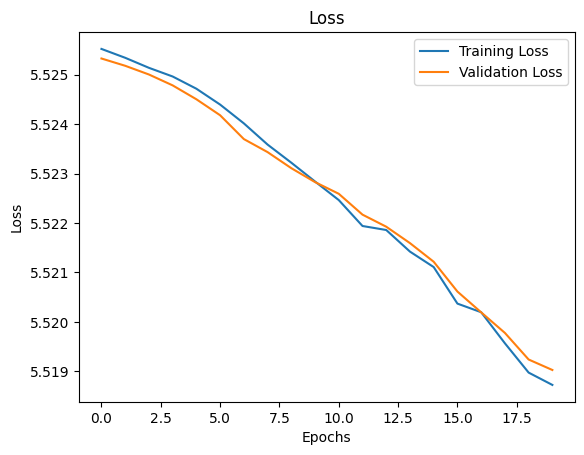

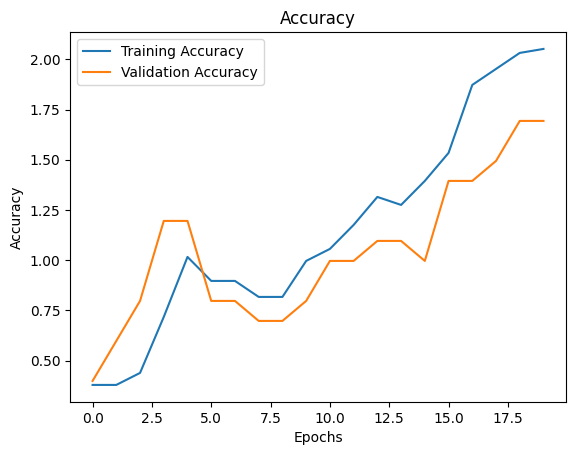

In [14]:
def plot_loss(train_loss,val_loss):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss')
    ax.plot(train_loss, label='Training Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.legend()

    plt.show()
plot_loss(train_loss,val_loss)
def plot_accuracy(train_acc,val_acc):
    fig, ax = plt.subplots()


    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy')
    ax.plot(train_acc, label='Training Accuracy')
    ax.plot(val_acc, label='Validation Accuracy')
    ax.legend()

    plt.show()
plot_accuracy(train_acc,val_acc)

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}')
    exEncoder.train()
    running_loss = 0.0
    correct = 0
    total = 0
    i = 0
    print("Training:")
    for inputs, labels in trainL:
        i=i+1
        if i%10 == 0:
            print(f'Batch {i} di {len(trainL)}')
        labels = [int(label) for label in labels]
        
        inputs = inputs.to(device) 
        labels = torch.tensor(labels, dtype=torch.long).to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = exEncoder(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Training Loss: {running_loss/len(trainL)}, Accuracy: {100*correct/total}%')
    train_acc.append(100*correct/total)
    train_loss.append(running_loss/len(trainL))
    print('Validation:')
    exEncoder.eval()
    running_loss = 0.0
    i = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,lables in valL:
            i+=1
            if i%10 == 0:
                print(f'Batch {i} di {len(valL)}')            
            lables=[int(lable) for lable in lables]
            inputs,lables = inputs.to(device), torch.tensor(lables,dtype=torch.long).to(device)
            outputs = exEncoder(inputs)
            _,predicted = torch.max(outputs,1)
            total += lables.size(0)
            correct += (predicted == lables).sum().item()
            loss = criterion(outputs,lables)
            running_loss += loss.item()
    print(f'Validation Loss: {running_loss/len(valL)}, Accuracy: {100*correct/total}%')
    val_loss.append(running_loss/len(valL))
    val_acc.append(100*correct/total)

In [28]:
from sklearn.metrics import confusion_matrix, top_k_accuracy_score


all_preds = []
all_labels = []
all_out = []
exEncoder.eval()
with torch.no_grad():
    for inputs,labels in test:
        labels = [int(label) for label in labels]
        inputs, labels = inputs.to(device), torch.tensor(labels, dtype=torch.long).to(device)
        outputs = exEncoder(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_out.extend(outputs.cpu().numpy())
        
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_out = np.array(all_out)
cm = confusion_matrix(all_labels, all_preds)

In [29]:
correct = (all_preds==all_labels).sum().item()

print(f'Accuracy: {100 * correct / len(ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda))}%')

Accuracy: 0.6253126563281641%


In [30]:
np.save("cmAutoEncoderModel10-5Epochs.npy",cm)
torch.save(exEncoder, "AutoEncoderModel.pth")